In [1]:
"""Lean Project Valuation Model - a three-stage cashflow model.

This simulates a cashflow process that follows geometric brownian motion and
a constant cost rate

Typical usage example:

  foo = ClassFoo()
  bar = foo.FunctionBar()
"""

import numpy as np
from numpy.random import RandomState
from numpy.polynomial import Polynomial
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from scipy.stats.distributions import lognorm, rv_frozen
from pathlib import Path

In [2]:
class CashflowProcess:
    """Cashflow Process - Geometric Brownian Motion.(with optional drift).

    Attributes:
        mu: drift of the cashflow process.
        sigma: volatility of the cashflow process.    
        y0: initial cashflow prediction.
    """

    def __init__(self, mu: float = 0.0, sigma: float = 1.0, y0: float = 3.0,):
        """Initializes the instance based on spam preference.
        """
        self.mu = mu
        self.sigma = sigma
        self.y0 = y0

    def _market_sentiment(self, t: np.array, n: int, step: int, rnd: np.random.RandomState) -> np.ndarray:
        """Generates a cumulative product array with uniform distribution draws
        at each interval period

        Parameters:
            t (np.array): The time array
            n (int): The number of simulations to run
            step (int): The number of time steps in an interval
            rnd (np.random.RandomState): The random state

        Returns:
            np.ndarray: A market sentiment array with innovations at each interval
        """
        # create an array of zeros
        time_len = t.size
        arr = np.ones((time_len, n))

        # replace every interval entry with a uniform distribution sample
        i = step
        while i < time_len:
            arr[i] = rnd.uniform(0, 2, size=(1, n))
            i += step
        
        # mask out the shocks
        time_mask = np.tile(np.reshape(t, (-1, 1)), (1, n))
        mask = np.mod(time_mask, 1) == 0
        shocks = np.ma.masked_where(~mask, arr)

        # take the cumulative product to identify the market sentiment effect
        return np.cumprod(arr, axis=0), shocks[~shocks.mask.any(axis=1)]

    def simulate(self, t: np.array, n: int, step: int, rnd: np.random.RandomState) -> np.ndarray:
        """Simulates cashflow process"""
        # verify input
        assert t.ndim == 1, "One dimensional time vector required"
        assert t.size > 0, "At least one time point is required"
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), "Increasing time vector required"
        
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)

        # market sentiment array
        mkt_sent, shocks = self._market_sentiment(t, n, step, rnd)

        # run simulation
        sim = (self.y0-1) + np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T
        return sim * mkt_sent, shocks

    def distribution(self, t: float) -> rv_frozen:
        """Return the distribution of the process"""
        mu_t = (self.mu - self.sigma**2 / 2) * t
        sigma_t = self.sigma * np.sqrt(t)
        return lognorm(scale=np.exp(mu_t), s=sigma_t)


In [3]:
# simulation parameters
N = 25
T = 3
step = 20
t1 = np.linspace(0, T, step*T+1)

# cost process
@np.vectorize
def cost(k):
    return 1.0

# cashflow process
r = 0.02
sigma = 0.3
cf = CashflowProcess(mu=r, sigma=sigma)

# simulation
rnd = RandomState(seed=1234)
cashflow, mkt_shocks = cf.simulate(t1, N, step, rnd)


In [4]:
# mask integer values so that the plot line breaks
time_mask = np.tile(np.reshape(t1, (-1, 1)), (1, N))
mask = np.mod(time_mask, 1) == 0  # Mask where x is an integer
cf_masked = np.ma.masked_where(mask, cashflow)
cf = cashflow

# sort based on final value
sorted_indices = np.argsort(cf[-1])
cf_sorted = cf[:, sorted_indices]

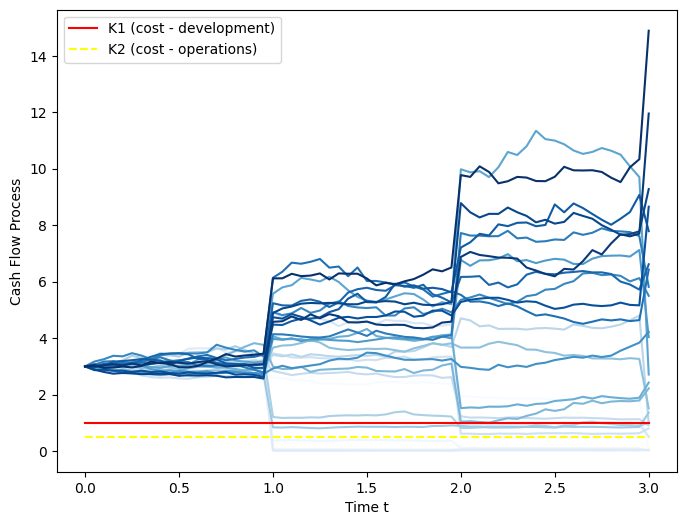


Trials: 25, Drift: 0.02, Vol: 0.3 



In [5]:
# plot cashflow and cost processes
figsize = (8, 6)
plt.figure(figsize=figsize)

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))
plt.plot(t1, cf_sorted)

plt.plot(t1, cost(t1), color='red', label='K1 (cost - development)')
plt.plot(t1, cost(t1)/2, color='yellow', linestyle='dashed', label='K2 (cost - operations)')

plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")
plt.legend(loc='upper left')
plt.show()

txt = f"""
Trials: {N}, Drift: {r}, Vol: {sigma} 
"""
print(txt)


In [6]:
# transform the market sentiment arrays into decision signs
d = mkt_shocks.data.copy()
d[0] = 0
for i in range(1, mkt_shocks.shape[0]):
    d[i] = np.sign(mkt_shocks[i]-1)

decisions = d.cumsum(axis=0)


In [30]:
# given no prior exercise we just receive the cashflow
cashflow = cf_sorted

# populate a results array for exercises and non-exercises
decision_results = []

# Determine completion, abandonment, and continuation series
completion_times = []
completions = []
abandon_times = []
abandons = []
continue_times = []
continues = []
for i in range(0, decisions.shape[0]):
    # time index
    idx = i*step

    # remaining cashflows in the path
    remaining_paths = cashflow[idx, :]

    # complete/abandon/continue decision
    dec = 0
    for j, d in enumerate(decisions[i]):
        if i >= 2 and d > 0:    # completion
            ex_idx = idx
            dec = 1
            completion_times.append(i)
            completions.append(cashflow[ex_idx, j])
        elif i >= 2 and d < 0:  # abandonment
            ex_idx = idx
            dec = -1
            abandon_times.append(i)
            abandons.append(cashflow[ex_idx, j])
        else:                   # continuation
            ex_idx = idx
            continue_times.append(i)
            continues.append(cashflow[ex_idx, j])

    # update decisions
    decision_results.append((remaining_paths, ex_idx, dec))


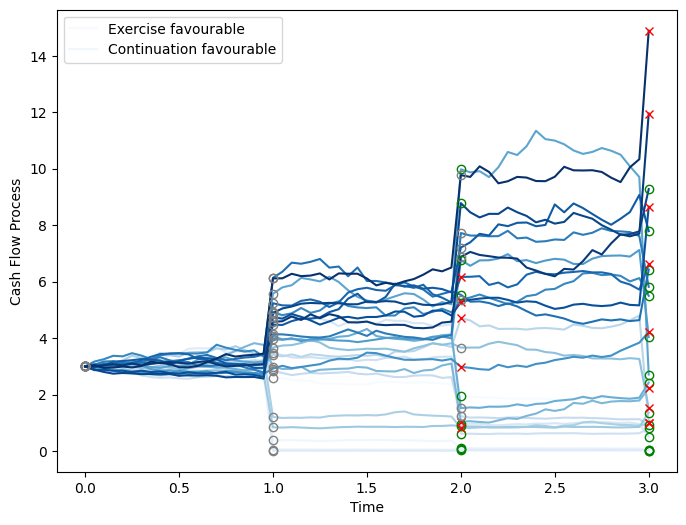

In [48]:
# Plot exercise and continuation
grey, green = "#dddddd", "#afe1af"
figsize = (8, 6)
plt.figure(figsize=figsize)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))
plt.plot(t1, cf_sorted)
plt.plot(completion_times, completions, "go", markerfacecolor='none')
plt.plot(abandon_times, abandons, "rx")
plt.plot(continue_times, continues, "o", color="grey", markerfacecolor='none')
plt.legend(["Exercise favourable", "Continuation favourable"])
plt.xlabel("Time")
plt.ylabel("Cash Flow Process")
plt.show()

# grey, green = "#dddddd", "#afe1af"
# figsize = (8, 6)
# plt.figure(figsize=figsize)
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))

# n_timesteps, n_paths = cf_sorted.shape
# for i in range(n_paths):
#     (handle_path,) = plt.plot(
#         t1[0 : completion_times[i] + 1],
#         cf_sorted[0 : completion_times[i] + 1, i],
#         "-",
#         color="#bbbbbb",
#     )
#     (handle_completed_path,) = plt.plot(
#         t1[completion_times[i] :], cf_sorted[completion_times[i] :, i], "--", color=green
#     )
#     (handle_abandoned_path,) = plt.plot(
#         t1[abandon_times[i] :], cf_sorted[abandon_times[i] :, i], "--", color=grey
#     )

#     if completion_times[i] < n_timesteps:
#         (handle_first_completion,) = plt.plot(
#             completion_times[i*step], cf_sorted[completion_times[i*step], i*step], "go"
#         )
    
#     if abandon_times[i] < n_timesteps:
#         (handle_first_abandon,) = plt.plot(
#             abandon_times[i*step], cf_sorted[abandon_times[i*step], i*step], "rx"
#         )
    
    

# plt.legend(
#     [handle_path, handle_completed_path, handle_abandoned_path, handle_first_completion, handle_first_abandon],
#     ["Path before exercise", "Path after completion", "Path after abandon", "First favourable completion", "First favourable abandon"],
# )
# plt.xlabel("Time t")
# plt.ylabel("Cash Flow Process")

In [ ]:
# Plot exercise and continuation
grey = "#dddddd"
# plt.figure(figsize=figsize)
# plt.plot(exercise_times, exercises, "rx")
# plt.plot(non_exercise_times, non_exercises, ".", color="grey")
# plt.legend(["Exercise favourable", "Continuation favourable"])
# plt.xlabel("Time")
# plt.ylabel("Cash Flow Process")
# plt.show()

n_timesteps, n_paths = cashflow.shape
for i in range(n_paths):
    (handle_path,) = plt.plot(
        t1[0 : first_exercise_idx[i] + 1],
        cashflow[0 : first_exercise_idx[i] + 1, i],
        "-",
        color="#bbbbbb",
    )
    (handle_stopped_path,) = plt.plot(
        t[first_exercise_idx[i] :], X[first_exercise_idx[i] :, i], "--", color=grey
    )
    if first_exercise_idx[i] < n_timesteps:
        (handle_first_ex,) = plt.plot(
            t[first_exercise_idx[i]], X[first_exercise_idx[i], i], "rx"
        )

plt.legend(
    [handle_path, handle_stopped_path, handle_first_ex],
    ["Path before exercise", "Path after exercise", "First favourable exercise"],
)
plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")